In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imp import load_source

aps = load_source(  'aggregate_player_stats', '../exploration/aggregate_player_stats.py' )
nps = load_source(  'normalize_player_stats', '../normalization/normalize_player_stats.py' )

%matplotlib inline

plt.rcParams['figure.figsize'] = (14,10)
plt.style.use('dark_background')

In [2]:
position = 'QB'
n_weeks  = 4
end_year = 2017

my_df = aps.generate_player_features( end_year, position, n_weeks=n_weeks )

In [3]:
target_variables = [
                    'log_pass_yds_1',
                    'pass_yds'
                   ]

meta_info     = [
                 'player_id',
                 'team',
                 'week',
                 'year',
                 'team_home_frac_prev_4',
#                 'few_reg_weeks'
                ]


player_scales = [
                 'pass_complete_prev_4',
                 'pass_incomplete_prev_4',
                 'pass_air_yds_prev_4',
                 'pass_air_yds_max_prev_4',
                 'pass_yds_prev_4',
                 'pass_att_prev_4'
                ]

player_norms = [
                'pass_int_prev_4',
                'pass_tds_prev_4',
                'rush_yds_prev_4',
                'rush_tds_prev_4',
                'rush_att_prev_4'
                ]

fumb_features    = [
                    'fumb_lost_prev_4', 
                    'fumb_rec_prev_4', 
                    'fumb_forced_prev_4', 
                    'fumb_nforced_prev_4'
                   ]

team_features    = [
                    'team_tds_prev_4',
                    'team_fg_made_prev_4',
                    'team_kickoffs_prev_4',
                    'team_punts_prev_4'
                   ]


opp_features     = [
                    'opp_avg_tds_prev_4', 
                    'opp_avg_fg_made_prev_4',
                    'opp_avg_rush_yds_prev_4', 
                    'opp_avg_pass_yds_prev_4',
                    'opp_avg_def_tkl_loss_prev_4', 
                    'opp_avg_def_sack_prev_4', 
                    'opp_avg_def_pass_def_prev_4'
                   ]

In [4]:
# Make turnovers a feature
temp_df = my_df.copy()

temp_df['turnovers'] = temp_df['pass_int']+temp_df['fumb_lost']
temp_df = temp_df.drop( ['pass_int','fumb_lost'], axis=1 )

# Not calc the frac of home games
temp_df['team_home_frac_prev_4'] = temp_df['team_home_flag_prev_4'] / \
                                  (temp_df['team_home_flag_prev_4'] +
                                   temp_df['team_away_flag_prev_4'] +
                                   0.                               )
temp_df = temp_df.drop( ['team_home_flag_prev_4','team_away_flag_prev_4'], axis=1 )


#
# Combine touchdowns
temp_df['tds'] = temp_df['pass_tds'] + temp_df['rush_tds']
temp_df = temp_df.drop( ['pass_tds','rush_tds'], axis=1 )

#
# Do logs of rush and passing yds
temp_df['log_pass_yds_1' ] = np.log10( temp_df['pass_yds']+ 1. ).fillna(0)
#temp_df['log_rush_yds_25'] = np.log10( temp_df['rush_yds']+25. )
#temp_df = temp_df.drop( ['pass_yds','rush_yds'], axis=1 )

#
# Only take regular seasons
temp_df = temp_df.loc[ temp_df['few_reg_weeks']==0 ]
temp_df = temp_df.drop( 'few_reg_weeks', axis=1 )

/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


In [5]:
# Let's start by training
#  on all data pre-2016
# Apparently 2017 preseason data missing from the db
my_train_data = temp_df.loc[ my_df['year']< 2017 ].reset_index().drop( 'index', axis=1 )
my_test_data  = temp_df.loc[ my_df['year']>=2017 ].reset_index().drop( 'index', axis=1 )

In [6]:
# Dictionary to save normalization data in
norm_dict = {}

# Do seperately
df_list = [
            my_train_data,
            my_test_data
          ]

out_df_list = []

# By looping over these,
#  will set data using train data,
#  then apply stuff to test data
# Adds then uses values from the dict
for frame in df_list:
    
    
    # Grab some normalized fumble features
    fumb_junk = nps.fumb_normalization( 
                                        frame, 
                                        fumb_features,
                                        norm_dict
                                      )
    
    # Some normalized team features
    team_junk = nps.team_normalization( 
                                        frame,
                                        team_features,
                                        norm_dict,
                                        'team_fg_miss_prev_4'
                                      )
    
    # Some opposing team features
    opp_junk = nps.opp_normalization( 
                                      frame,
                                      opp_features,
                                      norm_dict
                                    )
    
    # The QB features
    qb_junk = nps.qb_normalization(
                                    frame,
                                    player_norms,
                                    player_scales,
                                    norm_dict
                                  )
    
    # What we will output
    new_frame = frame[meta_info+target_variables]

    # Combine all the stuff into 1 frame
    out_df_list.append(
                        pd.concat( [
                                    new_frame,
                                    qb_junk,
                                    fumb_junk,
                                    team_junk,
                                    opp_junk
                                   ], axis=1).copy()
                      )
    
    
train_norm_data = out_df_list[0].copy()
test_norm_data  = out_df_list[1].copy()
out_df_list     = 0

In [8]:
# 21 features
features = test_norm_data.columns.values[7: ].tolist()+['team_home_frac_prev_4']

print test_norm_data.columns
print features

Index([                     u'player_id',                           u'team',
                                 u'week',                           u'year',
                u'team_home_frac_prev_4',                 u'log_pass_yds_1',
                             u'pass_yds',    u'pass_complete_prev_4_scaled',
        u'pass_incomplete_prev_4_scaled',     u'pass_air_yds_prev_4_scaled',
       u'pass_air_yds_max_prev_4_scaled',         u'pass_yds_prev_4_scaled',
               u'pass_att_prev_4_scaled',           u'pass_int_prev_4_norm',
                 u'pass_tds_prev_4_norm',           u'rush_yds_prev_4_norm',
                 u'rush_tds_prev_4_norm',           u'rush_att_prev_4_norm',
                      u'fumb_pca_0_norm',           u'fumb_pca_1_bc_scaled',
                    u'team_pca_0_scaled',              u'team_pca_1_scaled',
           u'team_fg_miss_prev_4_scaled',               u'opp_pca_0_scaled',
                     u'opp_pca_1_scaled',               u'opp_pca_2_scaled',

In [9]:
train_x = train_norm_data[features].values
test_x  =  test_norm_data[features].values

train_pass_yds     = train_norm_data['pass_yds'      ].values
train_pass_yds_log = train_norm_data['log_pass_yds_1'].values

test_pass_yds     = test_norm_data['pass_yds'      ].values
test_pass_yds_log = test_norm_data['log_pass_yds_1'].values

Let's pick some regressors. We will start with a linear regressor, lasso regressor, kneighbors, random forest, and neural network.

We'll do a first round test, select the best, and fine tune from there

In [10]:
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics         import accuracy_score
from sklearn.metrics         import precision_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import f1_score
from sklearn.metrics         import make_scorer

#tscv = TimeSeriesSplit(n_splits=3)
#TimeSeriesSplit(n_splits=3)
#>>> for train, test in tscv.split(X):
#param_grid = [
#{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#]

In [11]:
def n_f_rmse( estimator, x, y ):
    return -f_rmse( estimator.predict(x), y )

def n_rmse( estimator, x, y ):
    return -rmse( estimator.predict(x), y )

def f_rmse( pred, true ):
    return np.sqrt(((pred - true) ** 2).mean())/true.mean()

def rmse( pred, true ):
    return np.sqrt(((pred - true) ** 2).mean())

def r2( estimator, x, y ):
    # fit values, and mean
    yhat  = estimator.predict(x)     # or [p(z) for z in x]
    ybar  = np.sum(y)/len(y)         # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return ssreg / sstot
        
def rec_score( estimator, x, y ):
    xx = estimator.predict(x)
    return recall_score( y, xx, average='weighted' )
def prec_score( estimator, x, y ):
    xx = estimator.predict(x)
    return precision_score( y, xx, average='weighted' )
def f_score( estimator, x, y ):
    xx = estimator.predict(x)
    return f1_score( y, xx, average='weighted' )

# Feed a regressor in, as well as some grid parameters
# From there, train and test on the last split,
#  varying grid parameters
# Take the best performing regressor, and return it
def reg_cv( inp_reg, train_x, train_y, param_grid, scoring='r2' ):
    
    cv = GridSearchCV( inp_reg, param_grid, scoring=scoring )
    cv.fit( train_x, train_y )
    return cv.best_score_, cv.best_estimator_

# Go through different tests and report the results 
def test_reg( inp_reg, train_x, cv_y, test_x, test_y, param_grid ):
    
    # Get the best score, and best regressor for each criterion
    r2_score   ,    r2_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, r2      )
    rmse_score ,  rmse_reg = reg_cv( inp_reg, train_x, cv_y, param_grid,  n_rmse )
       
    # Predict for the test data
    r2_pred = r2_reg.   predict( test_x )
    rm_pred = rmse_reg. predict( test_x )
    
    # Score for the test data
    test_r2_score =     r2(  r2_reg, test_x, test_y )
    test_rm_score =   rmse( rm_pred,         test_y )
    
    print '\t\t Train   Test'
    print '\t   R^2 %8.4f %8.4f' % (     r2_score, test_r2_score )
    print '\t  RMSE %8.4f %8.4f' % (  -rmse_score, test_rm_score )
    print '\tF_RMSE %8.4f %8.4f' % (  -rmse_score/cv_y.mean(), test_rm_score/test_y.mean() )
    
    return r2_reg
    
# Go through different metrics, and report clf results
def test_clf( inp_reg, train_x, cv_y, test_x, test_y, param_grid ):
    
    # Get the best score, and best regressor for each criterion
    ac_score , ac_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, 'accuracy'   )
    rc_score , rc_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, rec_score    )
    pr_score , pr_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, prec_score   )
    f1_score , f1_reg = reg_cv( inp_reg, train_x, cv_y, param_grid, f_score      )    
       
    # Predict for the test data
    ac_pred = ac_reg.predict( test_x )
    
    # Score for the test data
    test_ac_score =  accuracy_score(         test_y, ac_pred )
    test_rc_score =       rec_score( rc_reg, test_x, test_y )
    test_pr_score =      prec_score( pr_reg, test_x, test_y )
    test_f1_score =         f_score( f1_reg, test_x, test_y )
    
    print '\t\t    Train   Test'
    print '\tAccuaracy %8.4f %8.4f' % ( ac_score, test_ac_score )
    print '\tRecall    %8.4f %8.4f' % ( rc_score, test_rc_score )
    print '\tPrecision %8.4f %8.4f' % ( pr_score, test_pr_score )
    print '\tF1        %8.4f %8.4f' % ( f1_score, test_f1_score )

    print ac_reg

In [54]:
#Random Forest
#		 Train   Test
#	   R^2   0.5030   0.5485
#	  RMSE  80.5699  83.4602
#	F_RMSE   0.3397   0.3644
print pass_dict['Random Forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


In [60]:
#Neural Net
#		 Train   Test
#	   R^2   1.2077   0.3929
#	  RMSE  80.7553  88.9286
#	F_RMSE   0.3404   0.3883
print pass_dict['Neural Net']

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [86]:
print 'Passing yds'
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

str_arr = []
grd_arr = []
clf_arr = []

lin_grid = {'fit_intercept':[True,False]}
rfr_grid = {
            'n_estimators':[3,5],
            'max_features':['log2'],
            }
nnr_grid = {
            'hidden_layer_sizes':[
                                  (10,),
                                 ],
            'alpha':[1e-3]
           }
grid_arr = [lin_grid,rfr_grid,nnr_grid]

lin_clf = LinearRegression     (              )
rfr_clf = RandomForestRegressor(random_state=0)
nnr_clf = MLPRegressor         (random_state=0)
clf_arr = [lin_clf,rfr_clf,nnr_clf]

lin_str = 'Linear Regression'
rfr_str = 'Random Forest'
nnr_str = 'Neural Net'
str_arr = [lin_str,rfr_str,nnr_str]

pass_dict = {}

for clf, s, grid in zip( clf_arr, str_arr, grid_arr ):
    print s
    pass_dict[s] = test_reg( clf, train_x, train_pass_yds, test_x, test_pass_yds, grid )
    print ''

Passing yds
Linear Regression
		 Train   Test
	   R^2   0.2049   0.1820
	  RMSE  77.8624  81.9231
	F_RMSE   0.3283   0.3577

Random Forest
		 Train   Test
	   R^2   0.5030   0.5485
	  RMSE  85.5309  86.7405
	F_RMSE   0.3606   0.3788

Neural Net
		 Train   Test
	   R^2   1.2077   0.3929
	  RMSE 121.6495  94.6892
	F_RMSE   0.5128   0.4135



In [76]:
#Random Forest
#		 Train   Test
#	   R^2   0.8570   0.6858
#	  RMSE   0.2771   0.3107
#	F_RMSE   0.1198   0.1359
print log_pass_dict['Random Forest']

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


In [78]:
#Neural Net
#		 Train   Test
#	   R^2   0.8949   0.7017
#	  RMSE   0.3293   0.3446
#	F_RMSE   0.1423   0.1507
print log_pass_dict['Neural Net']

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [85]:
print 'Log Passing yds'
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

str_arr = []
grd_arr = []
clf_arr = []

lin_grid = {'fit_intercept':[True,False]}
rfr_grid = {            'n_estimators':[3],     'criterion':['mae'] }
nnr_grid = {
            'hidden_layer_sizes':[
                                    (15,),
                                 ],
            'alpha':[1e-4]
           }
grid_arr = [lin_grid,rfr_grid,nnr_grid]

lin_clf = LinearRegression     (              )
rfr_clf = RandomForestRegressor(random_state=0)
nnr_clf = MLPRegressor         (random_state=0)
clf_arr = [lin_clf,rfr_clf,nnr_clf]

lin_str = 'Linear Regression'
rfr_str = 'Random Forest'
nnr_str = 'Neural Net'
str_arr = [lin_str,rfr_str,nnr_str]

log_pass_dict = {}

for clf, s, grid in zip( clf_arr, str_arr, grid_arr ):
    print s
    log_pass_dict[s] = test_reg( clf, train_x, train_pass_yds_log, test_x, test_pass_yds_log, grid )
    print ''

Log Passing yds
Linear Regression
		 Train   Test
	   R^2   0.3580   0.2731
	  RMSE   0.2933   0.3218
	F_RMSE   0.1268   0.1407

Random Forest
		 Train   Test
	   R^2   0.8570   0.6858
	  RMSE   0.3050   0.3232
	F_RMSE   0.1318   0.1414

Neural Net
		 Train   Test
	   R^2   0.8949   0.7017
	  RMSE   0.3415   0.3282
	F_RMSE   0.1476   0.1435



In [12]:
reg_strings = ['Linear Regression','Random Forest','Neural Net']

colorz  = ['g','b','r','c','m']
markerz = ['o','^','s','*','v']

#pass_dict
#rush_dict
#turn_dict
#td_dict

# test_pass_yds
# test_rush_yds
# test_turn
# test_tds

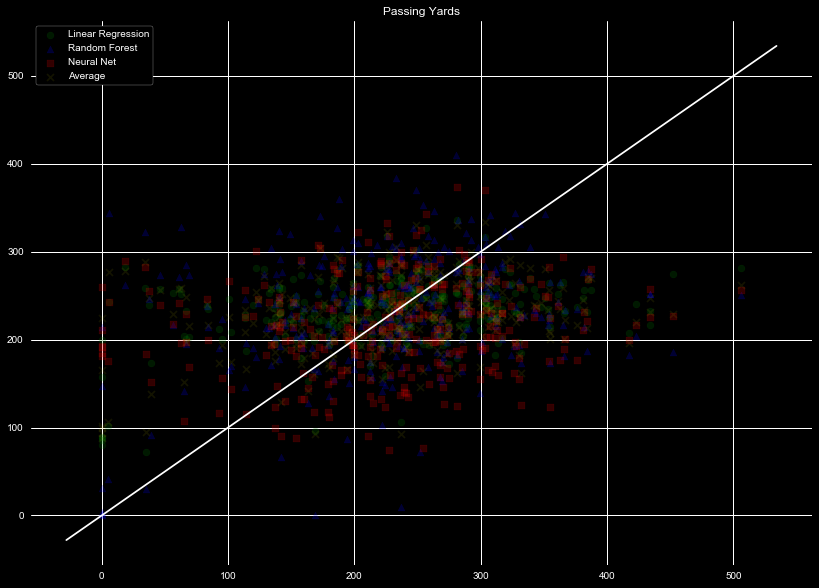

In [87]:
# Passing yards
my_tit  = 'Passing Yards'
my_strs = reg_strings
my_dict = pass_dict
y_real  = test_pass_yds
alpha   = 0.2


avg_vals = np.zeros( y_real.shape[0] )

fig, ax = plt.subplots()

for i in range( 0, len(my_strs) ):
    y_pred = my_dict[ my_strs[i] ].predict( test_x )
    
    avg_vals = avg_vals + y_pred
    
    ax.scatter( y_real, y_pred, color=colorz[i], marker=markerz[i], 
                linestyle='None', alpha=alpha, label=my_strs[i] )

avg_vals = avg_vals / ( i + 1. )

ax.scatter( y_real, avg_vals, color='y', marker='x', linestyle='None', alpha=alpha*0.5, label='Average' )

min_v = min( ax.get_ylim()[0], ax.get_xlim()[0] )
max_v = max( ax.get_ylim()[1], ax.get_xlim()[1] )

ax.plot( [min_v,max_v], [min_v,max_v], color='w' )

leg = plt.legend( loc=2, frameon=True )
leg.get_frame().set_alpha(1.0)
plt.title( my_tit )
plt.show()

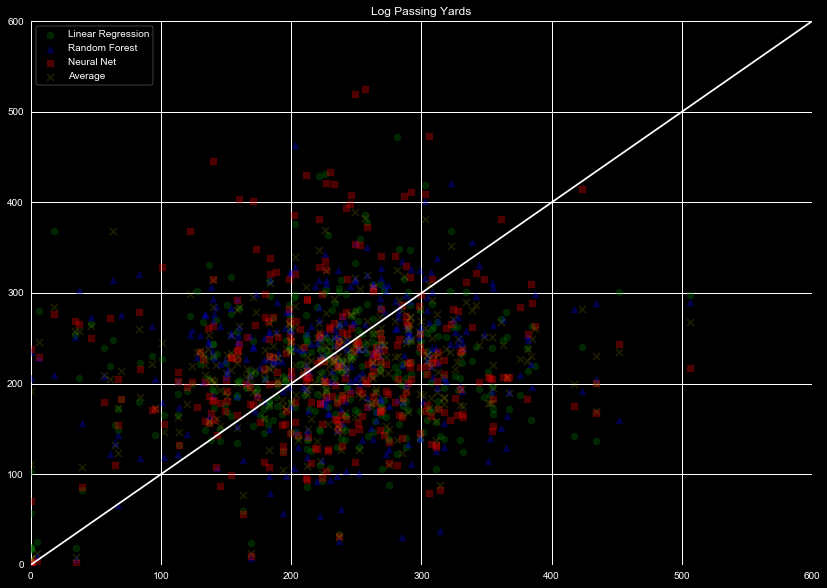

In [89]:
# Log Passing yards
my_tit  = 'Log Passing Yards'
my_strs = reg_strings
my_dict = log_pass_dict
y_real  = test_pass_yds_log
alpha   = 0.3


avg_vals = np.zeros( y_real.shape[0] )

fig, ax = plt.subplots()

for i in range( 0, len(my_strs) ):
    y_pred = 10**my_dict[ my_strs[i] ].predict( test_x ) - 1
    
    avg_vals = avg_vals + y_pred
    
    ax.scatter( 10**y_real-1, 
                    y_pred  , 
                color=colorz[i], marker=markerz[i], 
                linestyle='None', alpha=alpha, label=my_strs[i] )

avg_vals = avg_vals / ( i + 1. )

ax.scatter( 10**y_real-1, avg_vals, color='y', marker='x', linestyle='None', alpha=alpha*0.5, label='Average' )

min_v =   0#min( ax.get_ylim()[0], ax.get_xlim()[0] )
max_v = 600#max( ax.get_ylim()[1], ax.get_xlim()[1] )

ax.plot( [min_v,max_v], [min_v,max_v], color='w' )
ax.set_xlim( min_v, max_v )
ax.set_ylim( min_v, max_v )
leg = plt.legend( loc=2, frameon=True )
leg.get_frame().set_alpha(1.0)
plt.title( my_tit )
plt.show()

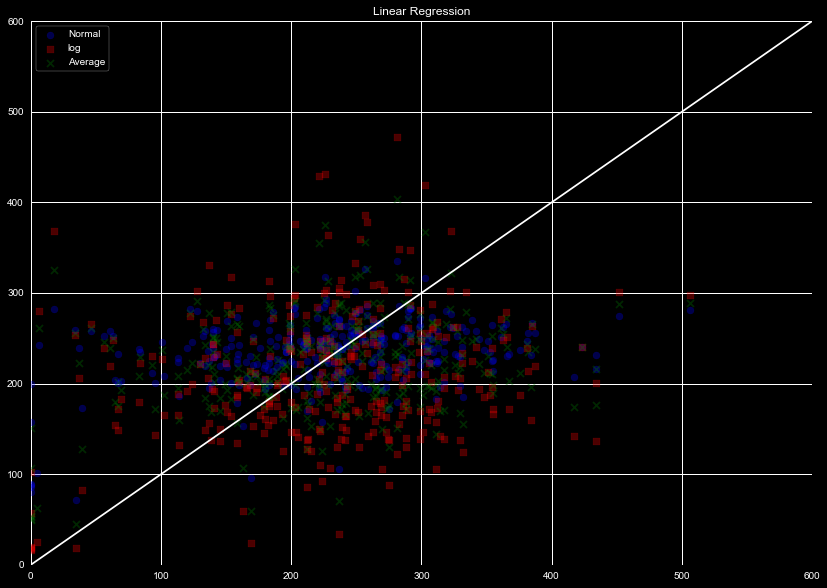

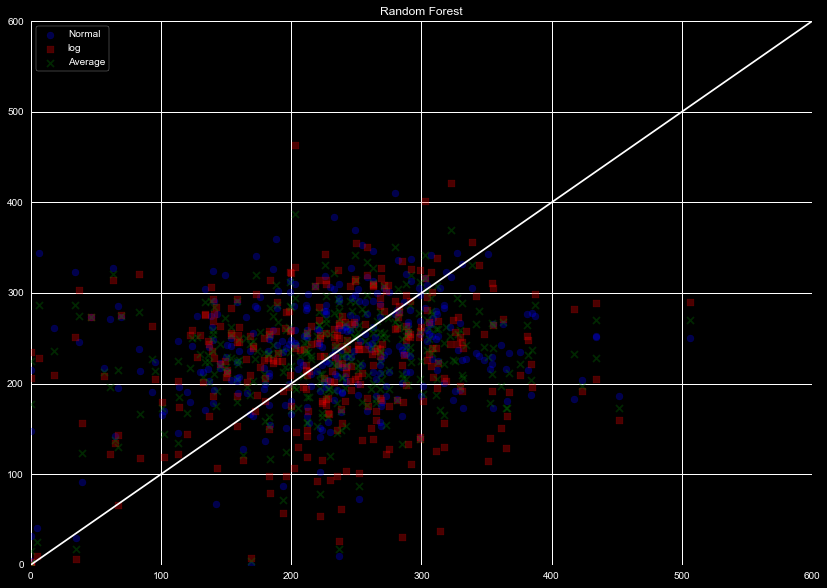

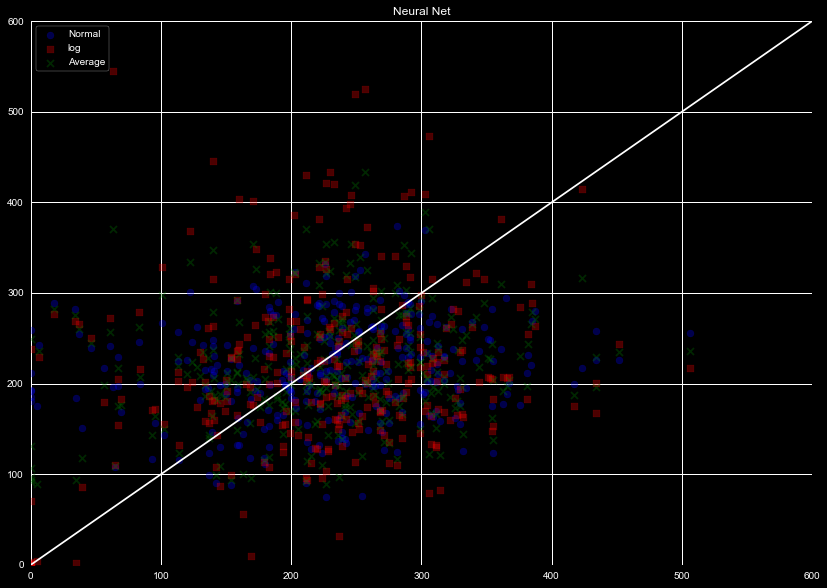

In [92]:
# Log Passing yards
my_strs = reg_strings
my_dict = pass_dict
y_real  = test_pass_yds
alpha   = 0.3


for i in range( 0, len(my_strs) ):
    avg_vals = np.zeros( y_real.shape[0] )

    fig, ax = plt.subplots()

    y_pred     =         pass_dict[ my_strs[i] ].predict( test_x )
    y_pred_log = 10**log_pass_dict[ my_strs[i] ].predict( test_x ) - 1
    
    avg_vals = y_pred + y_pred_log

    ax.scatter( y_real  , 
                y_pred  , 
                color='b', marker='o', 
                linestyle='None', alpha=alpha, label='Normal' )

    ax.scatter( y_real  , 
                y_pred_log, 
                color='r', marker='s', 
                linestyle='None', alpha=alpha, label='log' )

    avg_vals = avg_vals / 2.

    ax.scatter( y_real, avg_vals, color='g', marker='x', linestyle='None', alpha=alpha, label='Average' )

    min_v =   0#min( ax.get_ylim()[0], ax.get_xlim()[0] )
    max_v = 600#max( ax.get_ylim()[1], ax.get_xlim()[1] )

    ax.plot( [min_v,max_v], [min_v,max_v], color='w' )
    ax.set_xlim( min_v, max_v )
    ax.set_ylim( min_v, max_v )
    leg = plt.legend( loc=2, frameon=True )
    leg.get_frame().set_alpha(1.0)
    plt.title( my_strs[i] )
    plt.show()

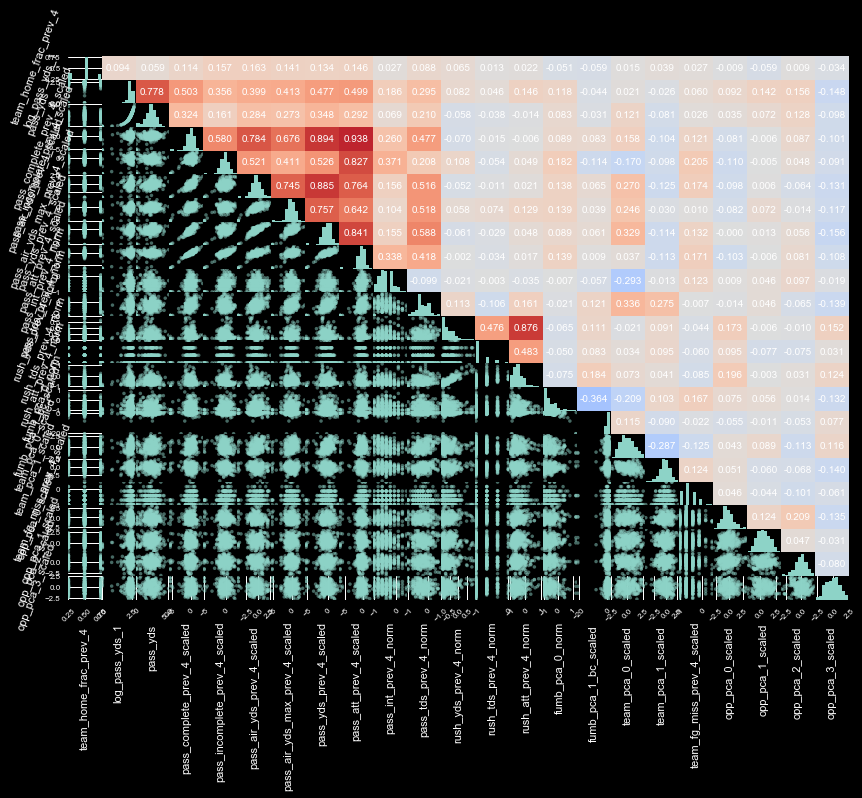

In [46]:
import df_visualizations as dv

dv.corr_plot( test_norm_data.drop(['player_id','team','week','year'], axis=1 ), x_label_rotation=90 )